In [1]:
a = 0.3
b = 0.5
import numpy as np

def lambda1(beta1, beta2):
    nom = (b-a)*(beta1-beta2)
    denom = (b-a-1)*beta2-(b-a)*beta1
    
    return nom/denom

def lambda2(beta1, beta2):
    nom = (b-a-1)*(beta1-beta2)
    denom = (b-a-1)*beta2-(b-a)*beta1
    
    return nom/denom

def effbeta(beta1, beta2):
    lam1 = lambda1(beta1, beta2)
    lam2 = lambda2(beta1, beta2)
    
    beta = beta1*(lam1+1)*(1+a-b)+beta2*(b-a)*(lam2+1)
    #beta = np.cos(beta1) + np.sin(beta2)
    return beta

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for the range of beta1 and beta2 values
beta1_range = np.linspace(0.05, 400, 100)
beta2_range = np.linspace(0.05, 400, 100)
beta1, beta2 = np.meshgrid(beta1_range, beta2_range)

# Compute effbeta for each combination of beta1 and beta2
eff_beta_values = effbeta(beta1, beta2)

# Create a heat plot
plt.figure(figsize=(10, 8))
plt.imshow(eff_beta_values, extent=(0.05, 400, 0.05, 400), origin='lower', aspect='auto')
plt.colorbar(label='effbeta')
plt.xlabel('beta1')
plt.ylabel('beta2')
plt.title('Heat Plot of effbeta')
plt.show()

# Create a surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(beta1, beta2, eff_beta_values, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('effbeta')
ax.set_title('Surface Plot of effbeta')
plt.show()

In [ ]:
from qulearn.qlayer import CircuitLayer
import pennylane as qml

class QFTLayer(CircuitLayer):

    def __init__(self, wires) -> None:
        super().__init__(wires)
        
    def circuit(self, _):
        qml.QFT(wires=self.wires)
        
class RYLayer(CircuitLayer):

    def __init__(self, wires) -> None:
        super().__init__(wires)
        
    def circuit(self, x):
        
        for xj, w in zip(x, self.wires):
            qml.RY(xj, w)

In [2]:
import pennylane as qml
from qulearn.qlayer import AltRotCXLayer, ParallelEntangledIQPEncoding, ParallelIQPEncoding, MeasurementLayer, MeasurementType, IQPERYCZLayer, RYCZLayer, IQPEAltRotCXLayer, HadamardLayer, HamiltonianLayer, IQPEmbeddingLayer, AltRXCXLayer
from qulearn.qkernel import QKernel
from qulearn.trainer import RidgeRegression
import torch
from torch.nn import MSELoss
import logging
from torch.utils.data import DataLoader, TensorDataset

num_features = 1
num_feature_repeat = 3
wires = num_features*num_feature_repeat
embed = ParallelIQPEncoding(wires, num_features=num_features, base=3.0, omega=1.0, n_repeat=1)
hads = HadamardLayer(wires=wires)
var = AltRotCXLayer(wires=wires, n_layers=2)
obs = qml.PauliZ(0)

qdevice = qml.device("default.qubit", wires=wires, shots=None)
interface = "torch"
diff_method = "backprop"

model = MeasurementLayer(embed, var, observable=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x1 = 2*torch.rand(num_features) - 1
print(drawer(x1))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(qml.specs(model.qnode)(x1))

0: ──H──RZ(0.45)──Rot(4.14,4.11,2.65)─╭●──Rot(3.37,1.34,5.11)─────────────────────────╭●
1: ──H──RZ(1.35)──Rot(1.68,1.05,2.01)─╰X──Rot(5.77,3.13,0.03)─╭●──Rot(3.18,3.69,3.34)─╰X
2: ──H──RZ(4.04)──Rot(1.53,4.05,6.16)─────────────────────────╰X──Rot(4.13,2.97,4.98)───

───Rot(2.87,0.91,2.66)─────────────────────────┤  <Z>
───Rot(1.32,1.32,5.69)─╭●──Rot(1.69,2.80,0.73)─┤     
───────────────────────╰X──Rot(1.51,3.18,5.79)─┤     
33
{'gate_sizes': defaultdict(<class 'int'>, {1: 14, 2: 4}), 'gate_types': defaultdict(<class 'int'>, {'IQPEmbedding': 3, 'Rot': 11, 'CNOT': 4}), 'num_operations': 18, 'num_observables': 1, 'num_diagonalizing_gates': 0, 'num_used_wires': 3, 'depth': 10, 'num_trainable_params': 33, 'num_device_wires': 3, 'device_name': 'default.qubit.torch', 'expansion_strategy': 'gradient', 'gradient_options': {}, 'interface': 'torch', 'diff_method': 'backprop', 'gradient_fn': 'backprop'}


In [ ]:
import torch
import torch.nn as nn
import itertools

class ClassicalSurrogate2(nn.Module):
    def __init__(self, num_features, max_frequency):
        super(ClassicalSurrogate2, self).__init__()
        
        self.num_features = num_features
        self.max_frequency = max_frequency
        self.frequency_range = list(range(-max_frequency, max_frequency + 1))
        self.num_omegas = len(self.frequency_range) ** num_features

        self.alpha = nn.Parameter(torch.empty(self.num_omegas, dtype=torch.float64))
        self.beta = nn.Parameter(torch.empty(self.num_omegas, dtype=torch.float64))
        nn.init.normal_(self.alpha)
        nn.init.normal_(self.beta)

        # Assume z_function is identity by default, can be replaced with any transformation
        self.z_function = lambda x: x

    def forward(self, x):
        z_x = self.z_function(x)
        outputs = torch.zeros(x.size(0), dtype=torch.float64)

        index = 0
        for omega in itertools.product(self.frequency_range, repeat=self.num_features):
            omega = torch.tensor(omega, dtype=torch.float64)

            # Compute dot product
            dot_product = torch.matmul(z_x, omega)

            # Compute cosine and sine values
            cos_value = torch.cos(dot_product)
            sin_value = torch.sin(dot_product)

            # Weighted sum of cosine and sine values for each sample
            outputs += self.alpha[index] * cos_value + self.beta[index] * sin_value
            index += 1

        return outputs.unsqueeze(1)
    
    def fit_fourier_coefficients(self, X, Y):
        with torch.no_grad():
            z_x = self.z_function(X)
            features_cos = []
            features_sin = []

            for omega in itertools.product(self.frequency_range, repeat=self.num_features):
                omega = torch.tensor(omega, dtype=torch.float64)

                # Compute dot product
                dot_product = torch.matmul(z_x, omega)

                # Compute cosine and sine values
                features_cos.append(torch.cos(dot_product))
                features_sin.append(torch.sin(dot_product))

            # Stack features
            features = torch.cat([torch.stack(features_cos).t(), torch.stack(features_sin).t()], dim=1)

            # Solve the least squares problem A*c = b
            coefficients = torch.linalg.lstsq(features, Y, driver='gelsd').solution.squeeze()

            # Update the parameters with the new coefficients
            self.alpha.data = coefficients[:self.num_omegas]
            self.beta.data = coefficients[self.num_omegas:]

In [11]:
import torch
import torch.nn as nn
import itertools

class ClassicalSurrogate(nn.Module):
    def __init__(self, num_features, max_frequency):
        super(ClassicalSurrogate, self).__init__()
        
        # Create the omega spectrum using all combinations of frequencies for each feature dimension
        frequency_range = range(-max_frequency, max_frequency + 1)
        omega_spectrum = list(itertools.product(frequency_range, repeat=num_features))
        self.omegas = torch.tensor(omega_spectrum, dtype=torch.float64)

        self.alpha = nn.Parameter(torch.empty(len(omega_spectrum), dtype=torch.float64))
        self.beta = nn.Parameter(torch.empty(len(omega_spectrum), dtype=torch.float64))
        nn.init.normal_(self.alpha)
        nn.init.normal_(self.beta)

        # Assume z_function is identity by default, can be replaced with any transformation
        self.z_function = lambda x: x

    def forward(self, x):
        z_x = self.z_function(x)
        
        # Compute dot product
        dot_products = torch.mm(z_x, self.omegas.t())
        
        # Compute cosine and sine values
        cos_values = torch.cos(dot_products)
        sin_values = torch.sin(dot_products)
        
        # Weighted sum of cosine and sine values for each sample
        outputs = torch.sum(self.alpha.squeeze() * cos_values + self.beta.squeeze() * sin_values, dim=1)
        return outputs.unsqueeze(1)
    
    def fit_fourier_coefficients(self, X, Y):
        with torch.no_grad():
            # Compute the feature vectors for the dataset
            z_x = self.z_function(X)
            dot_products = torch.mm(z_x, self.omegas.t())
            cos_values = torch.cos(dot_products)
            sin_values = torch.sin(dot_products)

            # Stack features and add a column for the bias term
            features = torch.cat([cos_values, sin_values], dim=1)

            # Solve the least squares problem A*c = b
            coefficients = torch.linalg.lstsq(features, Y, driver='gelsd').solution.squeeze()

            # Update the parameters with the new coefficients
            self.alpha.data = coefficients[:self.omegas.size(0)]
            self.beta.data = coefficients[self.omegas.size(0):]

# Example usage:
def id_z(x):
    # For demonstration, we're returning x. Replace this with any required transformation.
    return x

# Assuming z(x) is a 3-dimensional vector, and each component can take values [1.0, 2.0] or [2.0, 3.0] or [1.0, 3.0]
max_frequency = 3
num_features = 2
model = ClassicalSurrogate(num_features=num_features, max_frequency=max_frequency)

# Example forward pass:
x = torch.randn((1, num_features), dtype=torch.float64)
output = model(x)
print(output)
print(output.shape)

tensor([[0.1468]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 1])


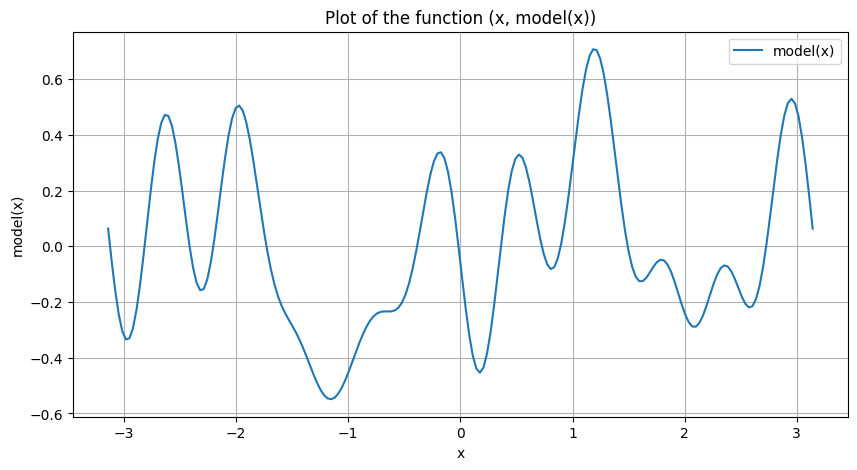

In [3]:
import torch
import matplotlib.pyplot as plt

# Assuming `model` is already defined and has a method `forward` that can be called with a torch tensor.
# Replace 'model' with your actual model variable.

# Define the range for x
a = torch.pi
x_values = torch.linspace(-a, a, steps=200, dtype=torch.float64)  # Replace -10 and 10 with your range of x values.

# Calculate model predictions
with torch.no_grad():  # We do not need to track gradients for this operation
    y_values = model(x_values.unsqueeze(1))
    #y_values_arcsin = torch.arctan(y_values)
    #y_values_arcsin = torch.zeros(len(y_values))

# Convert to numpy for plotting
x_values_np = x_values.numpy()
y_values_np = y_values.squeeze().numpy()
#y_values_np_arcsin = y_values_arcsin.squeeze().numpy()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_values_np, y_values_np, label='model(x)')
#plt.plot(x_values_np, y_values_np_arcsin, label='arcsin')
plt.xlabel('x')
plt.ylabel('model(x)')
plt.title('Plot of the function (x, model(x))')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input_dim = 8
# Define the LeakyReLU network
class LeakyReLUNet(nn.Module):
    def __init__(self, input_dim):
        super(LeakyReLUNet, self).__init__()
        # Define layers of the network (You can adjust the number of neurons as needed)
        dim = 8
        self.fc1 = nn.Linear(input_dim, dim, dtype=torch.float64)  # First fully connected layer
        self.fc2 = nn.Linear(dim, dim, dtype=torch.float64)         # Second fully connected layer
        #self.fc3 = nn.Linear(dim, dim, dtype=torch.float64)
        #self.fc4 = nn.Linear(dim, dim, dtype=torch.float64)
        self.fc5 = nn.Linear(dim, 1, dtype=torch.float64)          # Output layer

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        #x = F.leaky_relu(self.fc3(x))
        #x = F.leaky_relu(self.fc4(x))
        return self.fc5(x)
    
model = LeakyReLUNet(input_dim)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Fetch the California housing dataset
california_housing = fetch_california_housing()
X, Y = california_housing.data, california_housing.target

# Rescale the features to the range [-pi, pi]
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Convert arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).view(-1, 1)
X_valid = torch.tensor(X_valid, dtype=torch.float64)
Y_valid = torch.tensor(Y_valid, dtype=torch.float64).view(-1, 1)

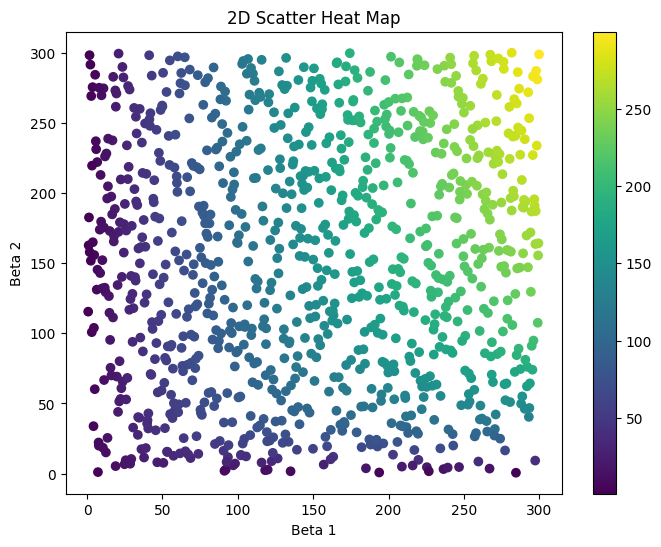

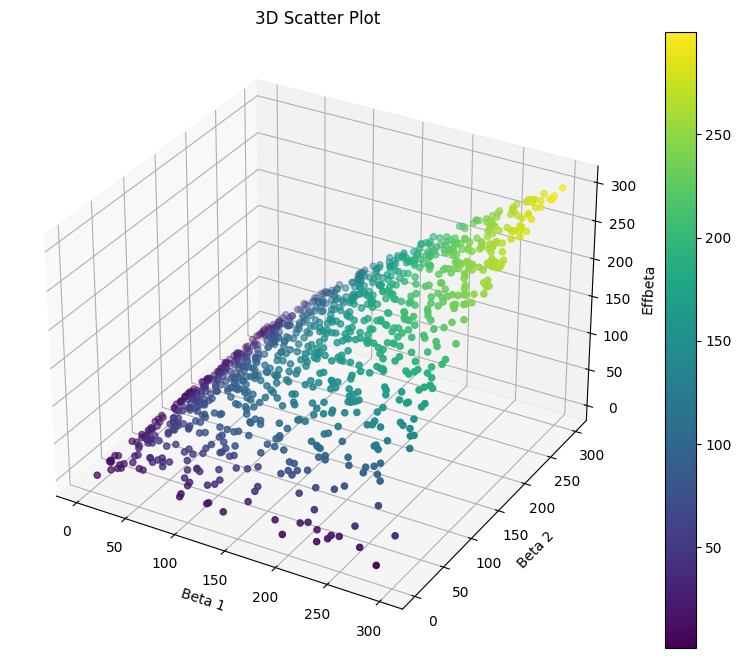

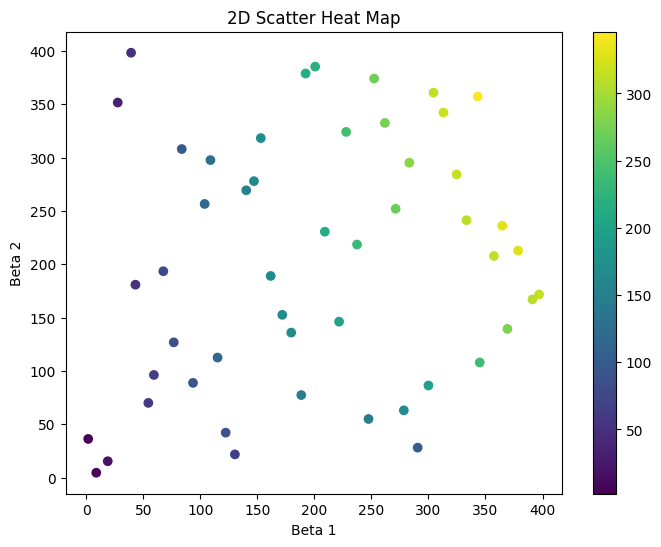

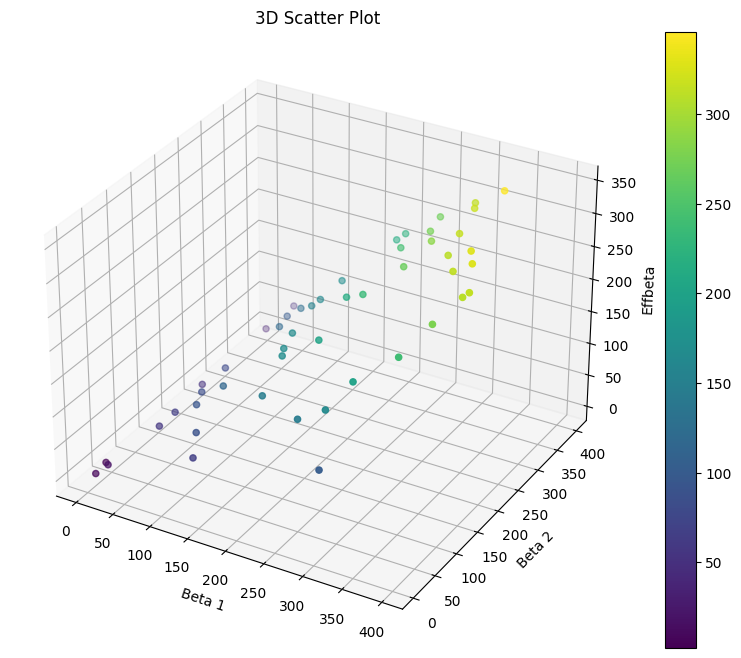

In [12]:
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate samples using Latin Hypercube Sampling
n_train = 1000  # Number of samples
n_valid = 50
lower_bounds = np.array([0.5, 0.5])
upper_bounds = np.array([300, 300])
X_train = lhs(2, samples=n_train)
X_train = lower_bounds + (upper_bounds - lower_bounds) * X_train

lower_bounds = np.array([0.05, 0.05])
upper_bounds = np.array([400, 400])
X_valid = lhs(2, samples=n_valid)
X_valid = lower_bounds + (upper_bounds - lower_bounds) * X_valid

# Evaluate the function at each sample point and add Gaussian noise
Y_train = np.array([effbeta(sample[0], sample[1]) for sample in X_train])
sigma = 0.001
noise = np.random.normal(0, sigma, Y_train.shape)
Y_train = Y_train + noise

Y_valid = np.array([effbeta(sample[0], sample[1]) for sample in X_valid])

# 2D Scatter Heat Map
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('Beta 1')
plt.ylabel('Beta 2')
plt.title('2D Scatter Heat Map')
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_train[:, 0], X_train[:, 1], Y_train, c=Y_train, cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel('Beta 1')
ax.set_ylabel('Beta 2')
ax.set_zlabel('Effbeta')
plt.title('3D Scatter Plot')
plt.show()

# 2D Scatter Heat Map
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_valid[:, 0], X_valid[:, 1], c=Y_valid, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('Beta 1')
plt.ylabel('Beta 2')
plt.title('2D Scatter Heat Map')
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_valid[:, 0], X_valid[:, 1], Y_valid, c=Y_valid, cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel('Beta 1')
ax.set_ylabel('Beta 2')
ax.set_zlabel('Effbeta')
plt.title('3D Scatter Plot')
plt.show()

# Convert arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).view(-1, 1)
X_valid = torch.tensor(X_valid, dtype=torch.float64)
Y_valid = torch.tensor(Y_valid, dtype=torch.float64).view(-1, 1)

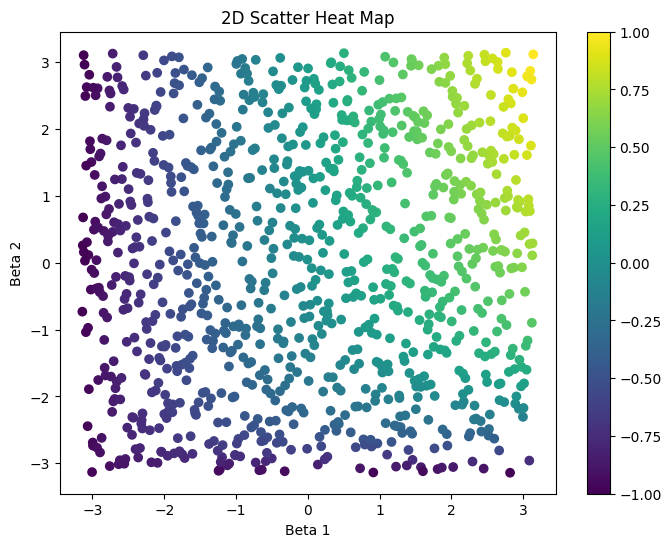

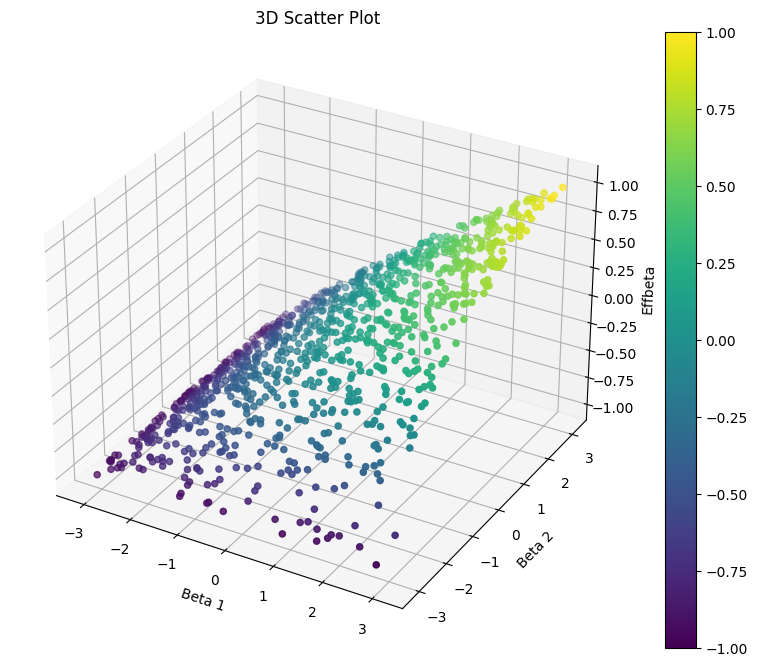

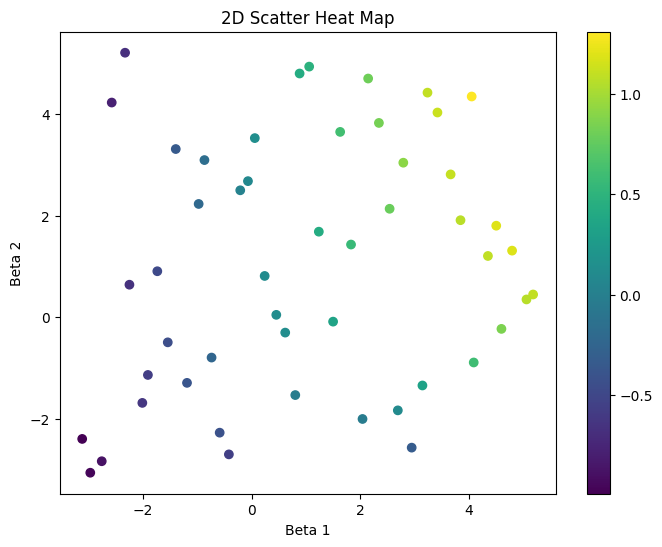

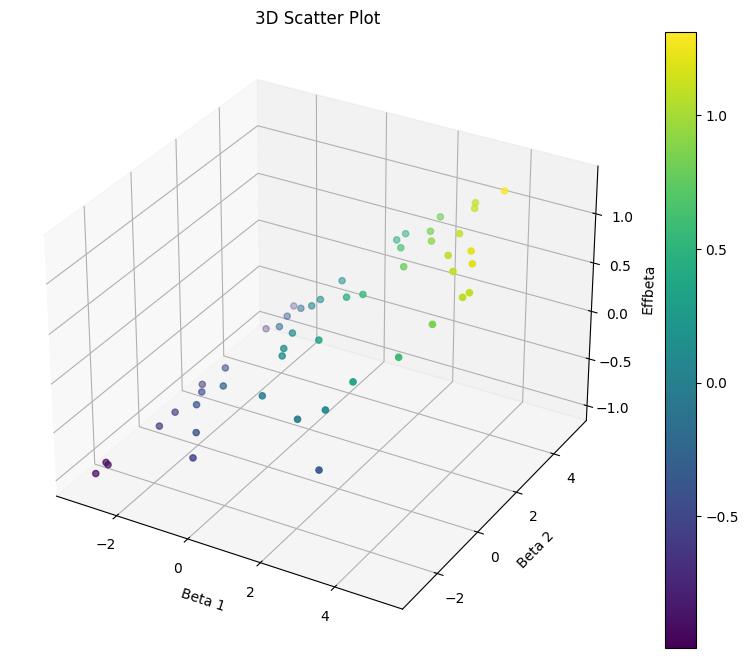

In [13]:
from sklearn.preprocessing import MinMaxScaler
# Rescale the features to the range [-pi, pi]
scaler_input = MinMaxScaler(feature_range=(-np.pi, np.pi))
scaler_output = MinMaxScaler(feature_range=(-1.0, 1.0))
scaler_input.fit(X_train)
scaler_output.fit(Y_train)
X_train = scaler_input.transform(X_train)
X_valid = scaler_input.transform(X_valid)
Y_train = scaler_output.transform(Y_train)
Y_valid = scaler_output.transform(Y_valid)

# plots
# 2D Scatter Heat Map
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('Beta 1')
plt.ylabel('Beta 2')
plt.title('2D Scatter Heat Map')
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_train[:, 0], X_train[:, 1], Y_train, c=Y_train, cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel('Beta 1')
ax.set_ylabel('Beta 2')
ax.set_zlabel('Effbeta')
plt.title('3D Scatter Plot')
plt.show()

# 2D Scatter Heat Map
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_valid[:, 0], X_valid[:, 1], c=Y_valid, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('Beta 1')
plt.ylabel('Beta 2')
plt.title('2D Scatter Heat Map')
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_valid[:, 0], X_valid[:, 1], Y_valid, c=Y_valid, cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel('Beta 1')
ax.set_ylabel('Beta 2')
ax.set_zlabel('Effbeta')
plt.title('3D Scatter Plot')
plt.show()

# Convert arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).view(-1, 1)
X_valid = torch.tensor(X_valid, dtype=torch.float64)
Y_valid = torch.tensor(Y_valid, dtype=torch.float64).view(-1, 1)

In [ ]:
import torch
import logging
from torch.optim import Adam, LBFGS
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset

# Data
X_train = torch.tensor(X_train, dtype=torch.float64)
X_valid = torch.tensor(X_valid, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).unsqueeze(1)
Y_valid = torch.tensor(Y_valid, dtype=torch.float64).unsqueeze(1)

In [14]:
import torch
import logging
from torch.optim import Adam, LBFGS
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.regression import MeanAbsolutePercentageError

batch_size=50
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=True)

# Trainer
lr = 0.1
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
loss_fn = torch.nn.MSELoss()
metric = MeanAbsolutePercentageError()

In [15]:

logger = logging.getLogger("train_function")
logger.setLevel(level=logging.INFO)
num_epochs = 200
trainer = SupervisedTrainer(optimizer=optimizer,
                            loss_fn=loss_fn,
                            metrics={"MARE": metric},
                            num_epochs=num_epochs,
                            logger=logger)

In [16]:
# Train
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 2.214307, Metrics: MARE: 12.563692


INFO:train_function:Validate - Epoch: 1, Loss: 2.718663, Metrics: MARE: 5.883986
INFO:train_function:Train - Epoch: 2, Loss: 0.501035, Metrics: MARE: 7.046862
INFO:train_function:Validate - Epoch: 2, Loss: 1.262677, Metrics: MARE: 3.801419
INFO:train_function:Train - Epoch: 3, Loss: 0.125703, Metrics: MARE: 2.918344
INFO:train_function:Validate - Epoch: 3, Loss: 0.908385, Metrics: MARE: 1.951529
INFO:train_function:Train - Epoch: 4, Loss: 0.095165, Metrics: MARE: 1.879834
INFO:train_function:Validate - Epoch: 4, Loss: 0.685192, Metrics: MARE: 1.263341
INFO:train_function:Train - Epoch: 5, Loss: 0.069087, Metrics: MARE: 1.742232
INFO:train_function:Validate - Epoch: 5, Loss: 0.777519, Metrics: MARE: 1.204513
INFO:train_function:Train - Epoch: 6, Loss: 0.070454, Metrics: MARE: 1.087048
INFO:train_function:Validate - Epoch: 6, Loss: 0.755619, Metrics: MARE: 0.971246
INFO:train_function:Train - Epoch: 7, Loss: 0.073784, Metrics: MARE: 1.026895
INFO:train_function:Validate - Epoch: 7, Loss:

In [ ]:
from torchmetrics.regression import MeanAbsolutePercentageError
predicted_train = model(X_train)
predicted_valid = model(X_valid)

metric = MeanAbsolutePercentageError()
loss_train = metric(predicted_train, Y_train)
loss_valid = metric(predicted_valid, Y_valid)
print("train loss: ", loss_train)
print("valid_loss: ", loss_valid)

In [ ]:

from torchmetrics.regression import MeanAbsolutePercentageError
model.fit_fourier_coefficients(X_train, Y_train)

In [ ]:

predicted_train = model(X_train)
predicted_valid = model(X_valid)

metric = MeanAbsolutePercentageError()
metric = torch.nn.MSELoss()
loss_train = metric(predicted_train, Y_train)
loss_valid = metric(predicted_valid, Y_valid)
print("train loss: ", loss_train)
print("valid_loss: ", loss_valid)

model = ClassicalSurrogate(id_z, all_combinations)

print(model.omegas)
alphas = np.zeros(9)
betas = np.zeros(9)
alphas[8] = 1.0
betas[5] = 1
#model.alpha.data = torch.tensor(alphas)
#model.beta.data = torch.tensor(betas)

grid_size = 10
x = np.linspace(1, 2, grid_size)
y = np.linspace(1, 2, grid_size)
X_train = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
Y_train = np.sin(X_train[:, 1])

X_train = torch.tensor(X_train, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).unsqueeze(1)

predicted = model(X_train)
loss = loss_fn(predicted, Y_train)
print("Before fitting: ", loss)

model.fit_fourier_coefficients(X_train, Y_train)

predicted = model(X_train)
loss = loss_fn(predicted, Y_train)
print("After fitting: ", loss)

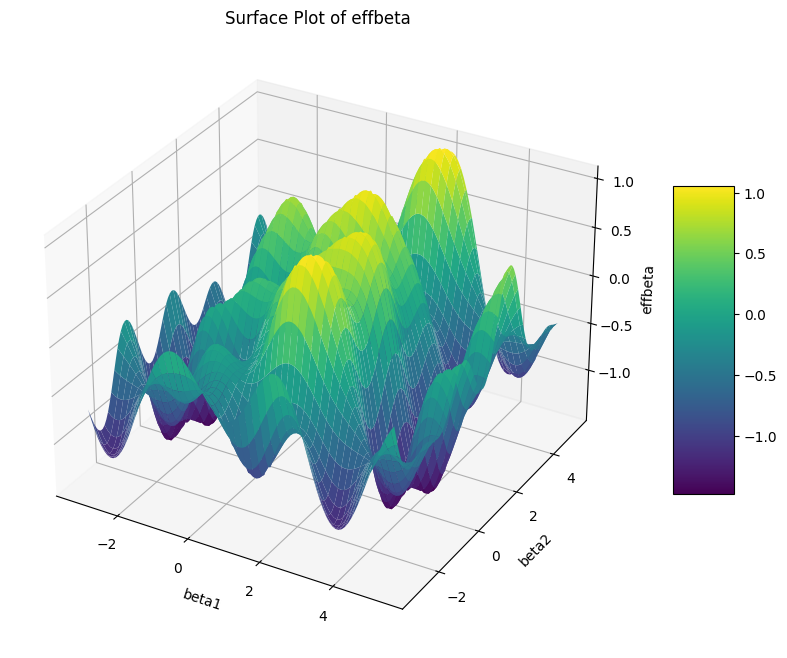

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for the range of beta1 and beta2 values
beta1_range = np.linspace(0.05, 400, 100)
beta2_range = np.linspace(0.05, 400, 100)

beta1, beta2 = np.meshgrid(beta1_range, beta2_range)
betas = np.vstack([beta1.ravel(), beta2.ravel()]).T
betas = scaler_input.transform(betas)
betas_tensor = torch.tensor(betas, dtype=torch.float64)

# Compute effbeta for each combination of beta1 and beta2
with torch.no_grad():
    predicted = model(betas_tensor)
    
predicted_reshaped = predicted.reshape(beta1.shape)

# Create a surface plot
beta1_original_flat, beta2_original_flat = np.split(betas, 2, axis=1)
# Reshape back to the original meshgrid format
beta1 = beta1_original_flat.reshape(beta1.shape)
beta2 = beta2_original_flat.reshape(beta2.shape)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(beta1, beta2, predicted_reshaped, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('effbeta')
ax.set_title('Surface Plot of effbeta')
plt.show()

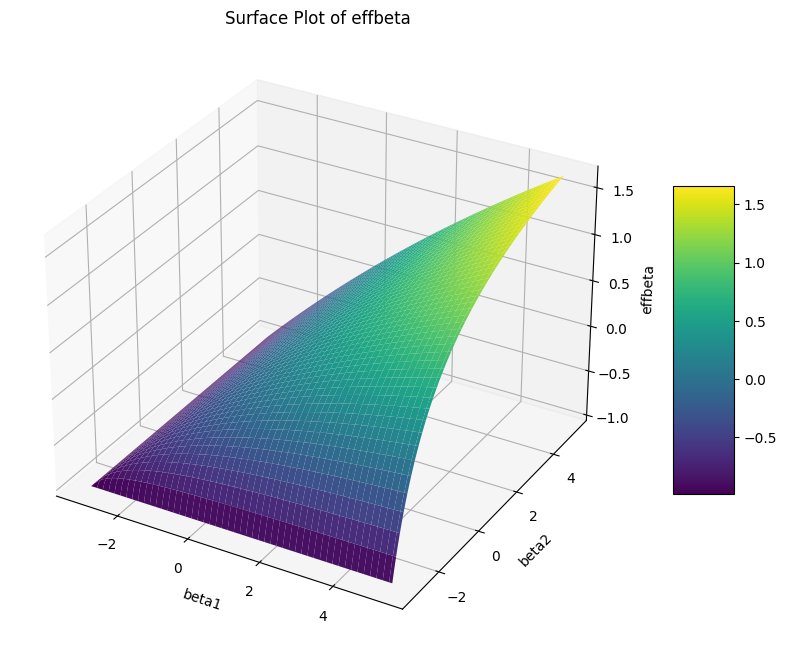

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for the range of beta1 and beta2 values
beta1_range = np.linspace(0.05, 400, 100)
beta2_range = np.linspace(0.05, 400, 100)
beta1, beta2 = np.meshgrid(beta1_range, beta2_range)

exact = effbeta(beta1, beta2)
exact_flat = exact.ravel().reshape(-1, 1)
exact_scaled_flat = scaler_output.transform(exact_flat)
exact_scaled = exact_scaled_flat.reshape(beta1.shape)

betas = np.vstack([beta1.ravel(), beta2.ravel()]).T
betas = scaler_input.transform(betas)
betas_tensor = torch.tensor(betas, dtype=torch.float64)

# Create a surface plot
beta1_original_flat, beta2_original_flat = np.split(betas, 2, axis=1)
# Reshape back to the original meshgrid format
beta1 = beta1_original_flat.reshape(beta1.shape)
beta2 = beta2_original_flat.reshape(beta2.shape)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(beta1, beta2, exact_scaled, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('effbeta')
ax.set_title('Surface Plot of effbeta')
plt.show()